**Reading from bedgraph**

In [1]:
import numpy as np
import csv

with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-miseq.bedgraph') as bed1:
#with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\test.txt') as bed1:
    bed1_reader = csv.reader(bed1, delimiter='\t')
    bed1_columns = list(zip(*bed1_reader))
    bed1_ranges = [(bed1_columns[1][i], bed1_columns[2][i]) for i in range(len(bed1_columns[1]))]
    bed1_score = bed1_columns[3]    
    
with open('C:\\Users\\Evi\\Documents\\2INF-LETO\\RP\\ref-nanopore.bedgraph') as bed2:
    bed2_reader = csv.reader(bed2, delimiter='\t')
    bed2_columns = list(zip(*bed2_reader))
    bed2_ranges = [(bed2_columns[1][i], bed2_columns[2][i]) for i in range(len(bed2_columns[1]))]
    bed2_score = bed2_columns[3]

**findDifferentChromIntervals function** returns a list of tuples that represent the <start, end) position for chromName

In [2]:
def findDifferentChromIntervals(columns):    
    chromIntervals = []
    chromName = columns[0][0]
    startIndex = 0
    index = 0

    for index in range(len(columns[0])):
        if columns[0][index] != chromName:
            chromIntervals.append((startIndex,index))
            startIndex = index
            chromName = columns[0][index]
    chromIntervals.append((startIndex, index+1))
           
    return chromIntervals

**Function to draw histograms for reads for every chromName**

In [3]:
from DrawDistributions import draw
from DrawErrors import drawErrors

def drawHistogramsForChromNames(chromIntervals, ranges, score):
    # Zadaj limitu pre os x>
    max_x=100

    # Zadaj pocet shiftnuti
    num_of_shifts = 4

    print(range(len(chromIntervals)))
    print(chromIntervals[0])

    #pre kazdy chromName si spravim histogram a zobrazim ho pomocou draw + drawErrors
    for chrom in range(len(chromIntervals)):
        histo = {}
        for i in range(chromIntervals[chrom][0],chromIntervals[chrom][1]) :
            #print('chrom = ', chrom, '   i = ', i)
            if int(score[i]) in histo:
                histo[int(score[i])] += (int(ranges[i][1])-int(ranges[i][0]))
            else:
                histo[int(score[i])] = (int(ranges[i][1])-int(ranges[i][0]))
        # treba vymazat 0, inak to pada
        if(0 in histo):
            del histo[0]
        data = draw(histo, max_x, num_of_shifts)
        drawErrors(data)
    print(len(histo))    
    print('Maximum number of read:', max(histo))

**Drawing histograms for reads for every chromName**

In [4]:
bed1_chromIntervals = findDifferentChromIntervals(bed1_columns)
print(bed1_chromIntervals) 

bed2_chromIntervals = findDifferentChromIntervals(bed2_columns)
print(bed2_chromIntervals)

[(0, 230387)]
[(0, 394197)]


range(0, 1)
(0, 230387)


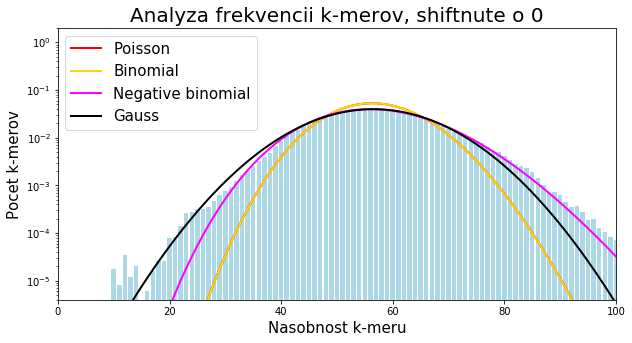

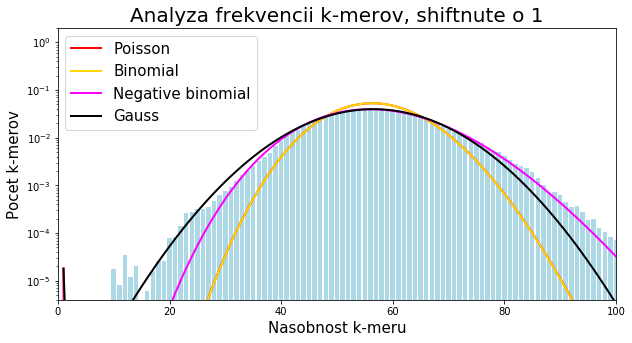

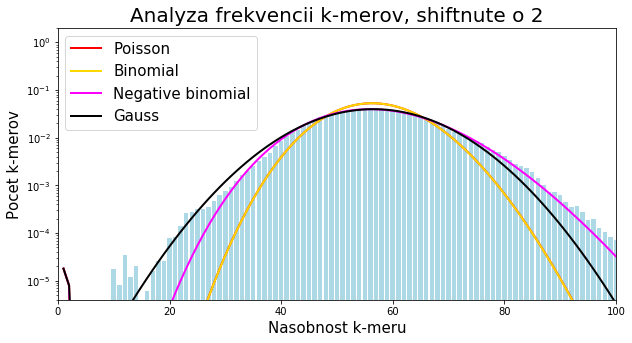

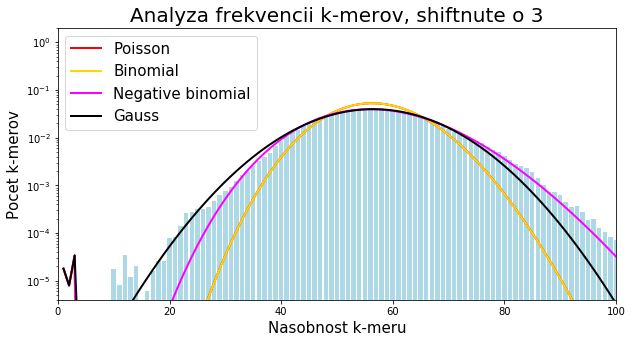

Top 3 for L1 norm:
Gauss , shifted:  3
Gauss , shifted:  2
Gauss , shifted:  1

Top 3 for L2 norm:
Gauss , shifted:  3
Gauss , shifted:  2
Gauss , shifted:  1


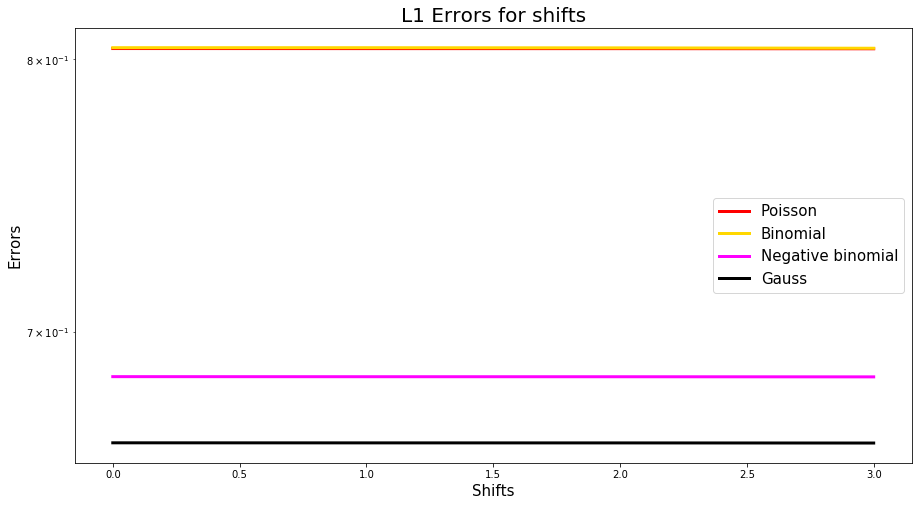

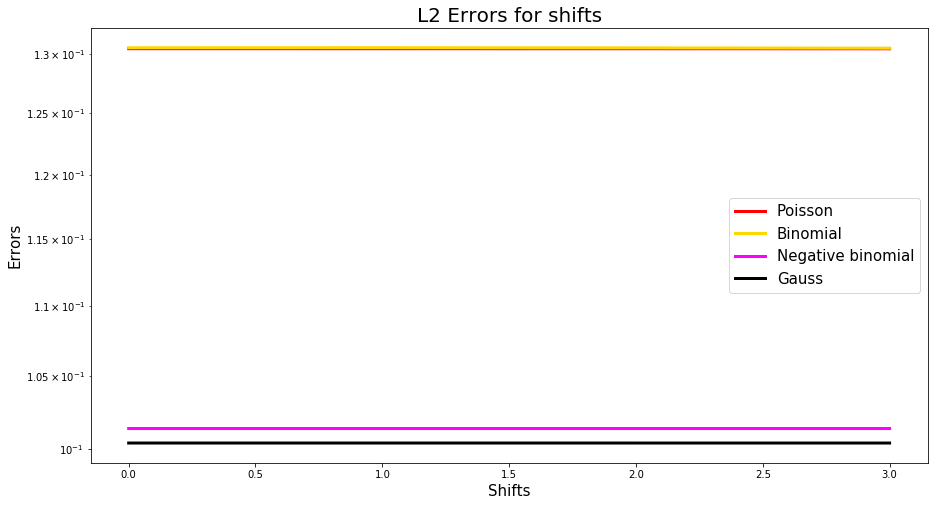

98
Maximum number of read: 107


In [5]:
drawHistogramsForChromNames(bed1_chromIntervals, bed1_ranges, bed1_score)

range(0, 1)
(0, 394197)


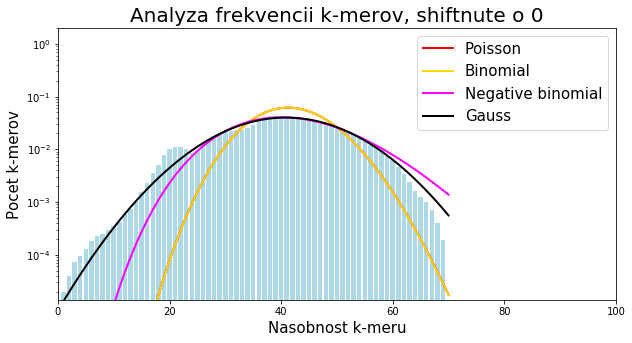

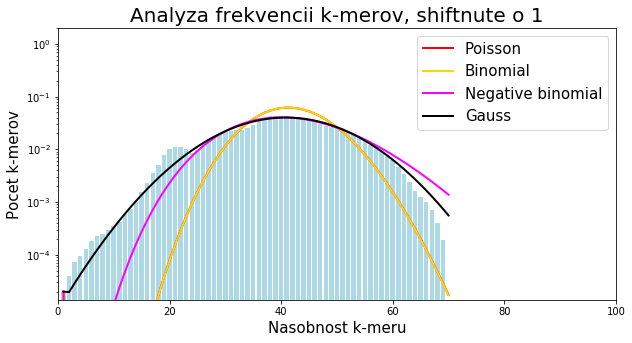

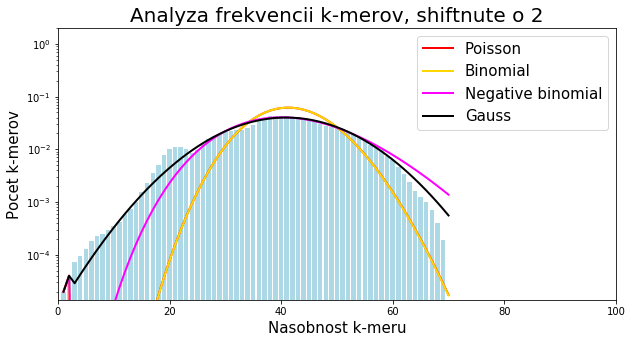

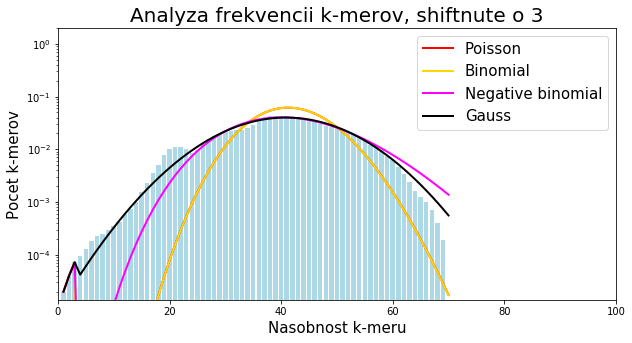

Top 3 for L1 norm:
Gauss , shifted:  3
Gauss , shifted:  2
Gauss , shifted:  1

Top 3 for L2 norm:
Gauss , shifted:  3
Gauss , shifted:  2
Gauss , shifted:  1


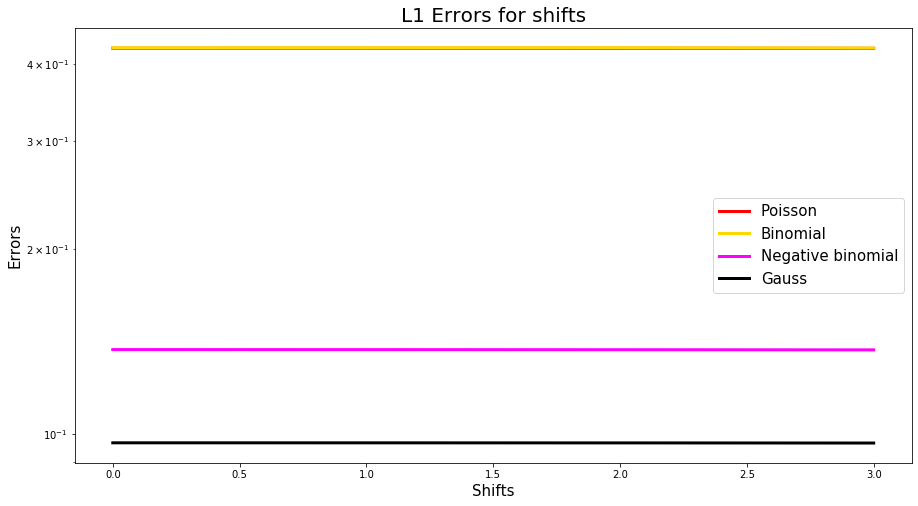

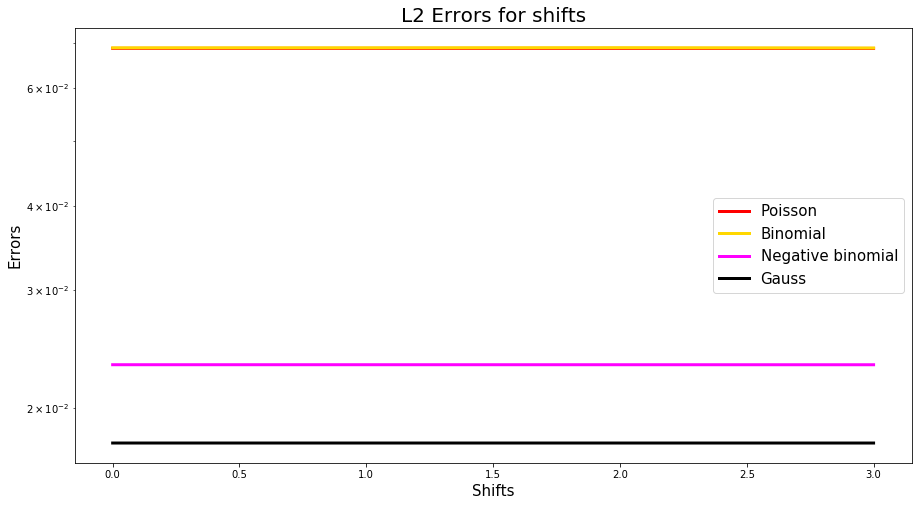

70
Maximum number of read: 70


In [6]:
drawHistogramsForChromNames(bed2_chromIntervals, bed2_ranges, bed2_score)

**Visualizing 2bedgraphs with 2D heatmap**

Format of the bedgraph:
*chrom chromStart chromEnd dataValue*

We can assign to each position 2 numbers - the number of reads (*dataValue*) from both bedgarphs. Below with the 2D heatmap is visualized the frequency for *dataValue*

In [7]:
bg1 = []
for r in range(len(bed1_ranges)):  
    bg1 += (int(bed1_ranges[r][1])-int(bed1_ranges[r][0])) * [int(bed1_score[r])]
    
bg2 = []
for r in range(len(bed2_ranges)):  
    bg2 += (int(bed2_ranges[r][1])-int(bed2_ranges[r][0])) * [int(bed2_score[r])]
    

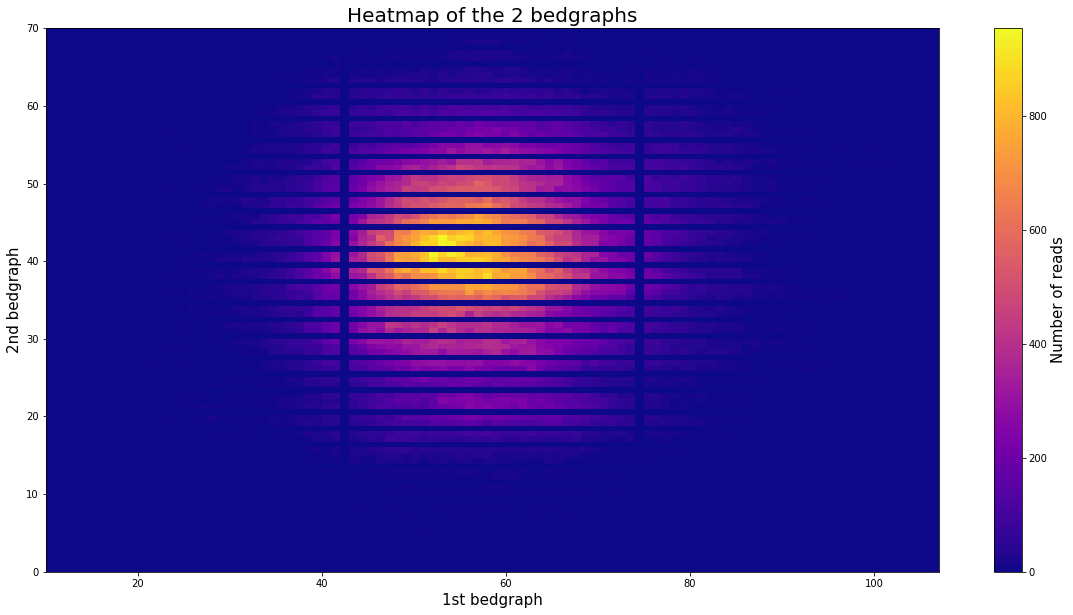

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(bg1)
y = np.array(bg2)

plt.figure(figsize=(20,10))    
plt.hist2d(x, y, bins=100, cmap='plasma')

cb = plt.colorbar()
cb.set_label('Number of reads', fontsize=15)

plt.title('Heatmap of the 2 bedgraphs', fontsize=20)
plt.xlabel('1st bedgraph', fontsize=15)
plt.ylabel('2nd bedgraph', fontsize=15)

plt.show()